<a href="https://colab.research.google.com/github/mulqueenr/DSWG_MethylationWorkshop/blob/main/DSWG_Methylation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the DSWG Methylation workshop!

I'll be running you through an vignette of amethyst processing, based heavily off the vignette for [PBMC processing available on the amethyst github repo.](https://htmlpreview.github.io/?https://github.com/lrylaarsdam/amethyst/blob/main/vignettes/pbmc_vignette/pbmc_vignette.html)

We will be processing from breast cancer cell line cells: [MDA-MB-231](https://en.wikipedia.org/wiki/MDA-MB231), [MCF7](https://en.wikipedia.org/wiki/MCF-7), and [MCF10A](https://www.cellosaurus.org/CVCL_0598)

Our goals in this workshop are to:

1. Get introduced to data structures of amethyst.
2. Get familiar with quality metrics of DNA methylation.
3. Cluster single cell methylomes to separate out the cell lines.
4. (optional) Perform copy number calling to confirm our clusters.

## Library Installation

I prebuilt some R libraries that we can use to skip the install process. If you want to run the install yourself, the code is commented out below. However, you can fully ignore the commented out code below. All it is showing is that we need to install quite a few dependencies to get to the installation of two packages that will be the focus on this workshop:

- **amethyst**: single cell methylation processing
- **copykit**: single cell whole genome copy number calling

In [30]:
#first lets install packages for the tutorial
# this is prerun and stored on google drive to save time

#install.packages("BiocManager")

#library("BiocManager")
#BiocManager::install(c("caret", "devtools", "data.table", "dplyr", "furrr", "future", "future.apply",
#  "ggplot2", "grDevices", "gridExtra", "igraph", "irlba", "janitor", "Matrix", "methods", "pheatmap",
#  "plotly", "plyr", "purrr", "randomForest", "rhdf5", "rtracklayer", "Rtsne", "scales", "stats", "stringr",
#  "tibble", "tidyr", "umap", "utils"))

#library("devtools")

#devtools::install_github("JinmiaoChenLab/Rphenograph")
#devtools::install_github("KrishnaswamyLab/MAGIC/Rmagic")
#devtools::install_github("TomKellyGenetics/leiden")
#installing older version of amethyst for compatibility with cell line data files.
#system('wget https://github.com/lrylaarsdam/amethyst/releases/download/v0.0.0.9000/amethyst_0.0.0.9000.tar.gz')
#system('tar -xf amethyst_0.0.0.9000.tar.gz')
#devtools::install("/content/amethyst")
#devtools::install_github("navinlabcode/copykit")
#system('cd /usr/local/lib/R/site-library/; tar -czf /content/R_library.tar.gz *; cd /content')



To save ~30min of installation time, I prebuild the library and uploaded to a google drive folder. The following code downloads the libraries, and uncompresses them, so we can use them in our R session.


> *system()* takes a string and calls it in the terminal above. Likewise, we can run these string commands using the terminal button on the bottom left of colab.



In [31]:
#download prebuilt R libraries
system("gdown '1r2P-GZa2QukEl-i619yK7dqeoEhGjBNN'")
system("mkdir R_library")
system("tar -xvf R_library.tar.gz -C R_library") #unpack the library

We'll also download the cell line methylation data while here.

In [32]:
#download data
system("gdown '195TI6-r2ruEGaKK4rIfWa24aT2xyEjL5'")
system("tar -xf workshop_data.tar.gz") #unpack the library

If you check your files for this colab session, you should see them populate with two folders:

- **R_library.tar.gz** : this is our downloaded compressed libraries
- **/R_library/** : this is our decompressed folder
- **h5_files** : this contains our methylation data in compressed h5 format
- **metadata.tsv** : this is a tab-separated format of our metadata
- **workshop.copykit.obj.rds** : this is a bonus copykit object that we will use for cnv calling

Now all we have to do is tell R where to look for these libraries and we should be good to go!

To do this, we are going to append the folder location to an R environment variable called ".libPaths".

Following this we will load our packages.



> *library()* loads packages into the R runtime.



In [33]:
.libPaths(c("/content/R_library", .libPaths()))
library(amethyst) #for methylation analysis
library(copykit) #for cnv calling
library(ggplot2) #for plotting
library(cowplot) #for combining plots
.libPaths()

[1] "/content/R_library"            "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"

# Let's Assemble our Amethyst Object

![amethyst_layout.png](https://github.com/lrylaarsdam/amethyst/blob/main/images/objectstructure.png?raw=true)

## Read in our data




> *read.csv* reads in a file, by default a comma separated value (csv) file. We are going to specify that the separators are tabs (a tsv) file.



In [34]:
meta<-read.csv(file="/content/metadata.tsv",header=T,sep="\t")
head(meta)

,cell_id,tgmt_well,i5_well,i7_well,plate,batch,plate_info,unique_reads,total_reads,mito_reads,mcg_pct,cov,ch_cov,tss_enrich,cg_cov,mch_pct,sample
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+CTTCGGCGCA+AACTGTAG,1A06,E01,A05,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,691748,1148393,0.001,68.92,12034132,11566095,0.7604,468037,0.68,MCF10A
GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+TCGTAGGCTT+AACTGTAG,1A06,H01,A06,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,640821,1037107,0.001,69.59,11440496,11008909,0.7406,431587,0.67,MCF10A
GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+ACCGGAATTA+ATAATGTG,1B03,D01,A06,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,555624,905954,0.001,68.82,9897578,9523222,0.7230,374356,0.71,MCF10A
AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,AATTGAGAGA+TCGTAGGCTT+AACTGTAG,1A06,H01,A11,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,536382,873647,0.001,69.03,9525741,9162261,0.6952,363480,0.66,MCF10A
TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,TCGAAGCGCG+GGCAATGAGA+ATAATGTG,1B03,B01,A07,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,497105,776195,0.000,69.49,9038954,8701616,0.7497,337338,0.69,MCF10A
CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+GGCAATGAGA+AACTGTAG,1A06,B01,A05,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,435953,736252,0.000,70.15,7644320,7353858,0.7426,290462,0.70,MCF10A


In [35]:
#read in our h5 filesobj <- addCellInfo(obj, file = "metadata.tsv")
h5_paths<-read.csv(file="/content/h5_files/h5_paths.tsv",header=T,sep="\t")
h5_paths$barcodes<-row.names(h5_paths)
h5_paths$paths<-h5_paths$path
h5_paths<-h5_paths[,c("barcodes","paths")]
head(h5_paths)

,barcodes,paths
,<chr>,<chr>
CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5
GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5
GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1B03_cov.h5
AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5
TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1B03_cov.h5
CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5


## Create an empty Amethyst Object

You'll notice for both the h5 paths and the metadata, the row names of the files are the same. So through this we will like our cell info to the methylation profiles! Now let's make a new amethyst object.



> *str()* calls the "structure" of an object. This can be a simple type (i.e. character or numeric) or can show the hierarchical layout of a fancier structure. Its great practice to know how and where your data is stored in an object!



In [36]:
obj <- createObject()
str(obj)

Formal class 'amethyst' [package "amethyst"] with 6 slots
  ..@ h5paths       : NULL
  ..@ genomeMatrices: NULL
  ..@ reductions    : NULL
  ..@ index         : NULL
  ..@ metadata      : NULL
  ..@ ref           : NULL


The "@" symbol shows a slot in the object. These are predefined in R, so they only accept certain data types and formats.

## Add our data to the object

We will start by adding our metadata into the @metadata slot and h5 paths into the @h5paths slot. Then we will add reference data using a handy wrapper function for amethyst. This will give us gene locations along the genome, which will be useful for plotting later.

We'll then just do another quick check to make sure it got added correctly.

In [37]:
obj@metadata<-meta
obj@h5paths<-h5_paths[row.names(meta),]

R structured objects are hierarchical. So we can call a slot, and then call further objected within that slot.

Let's make a quick counts table of our "sample" metadata column.

In [38]:
table(obj@metadata$sample)



    MCF10A       MCF7 MDA-MB-231 
        55         52         48 

### QC Plot: All Cytosines covered

Looks like we're working with about 50 cells a-piece for the 3 different cell lines. Let's take a peek at the cytosine coverage per cell as a histogram.

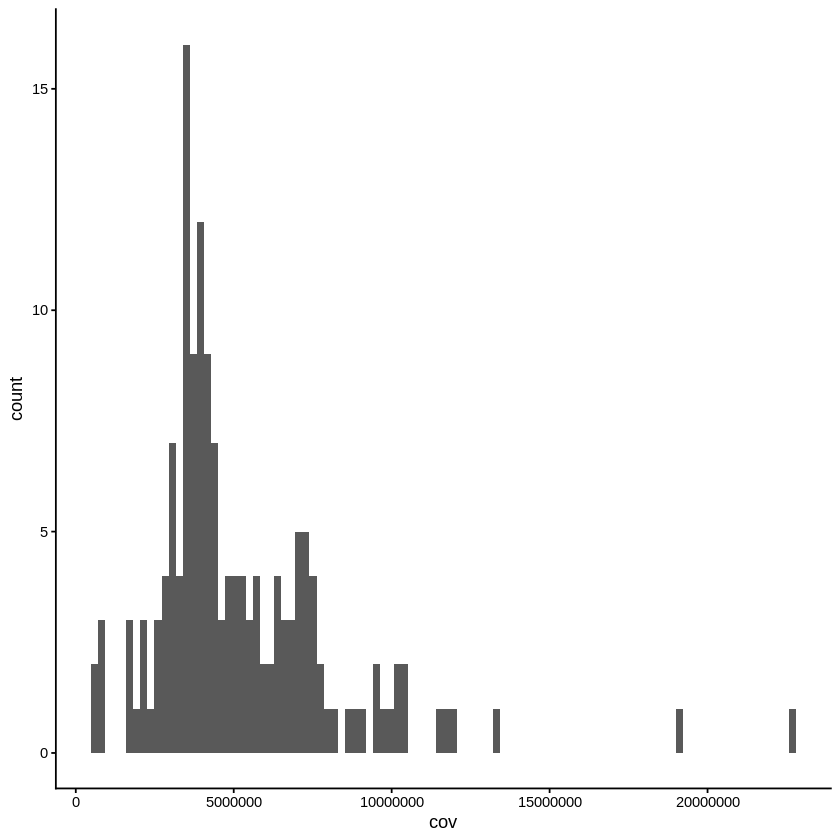

In [39]:
ggplot(obj@metadata, aes(x = cov)) +
  geom_histogram(bins = 100) +
  theme_classic()

### QC Plot: CGs covered

And now just the CG dinucleotide coverage. By Calling a similar function, but just changing the metadata column.

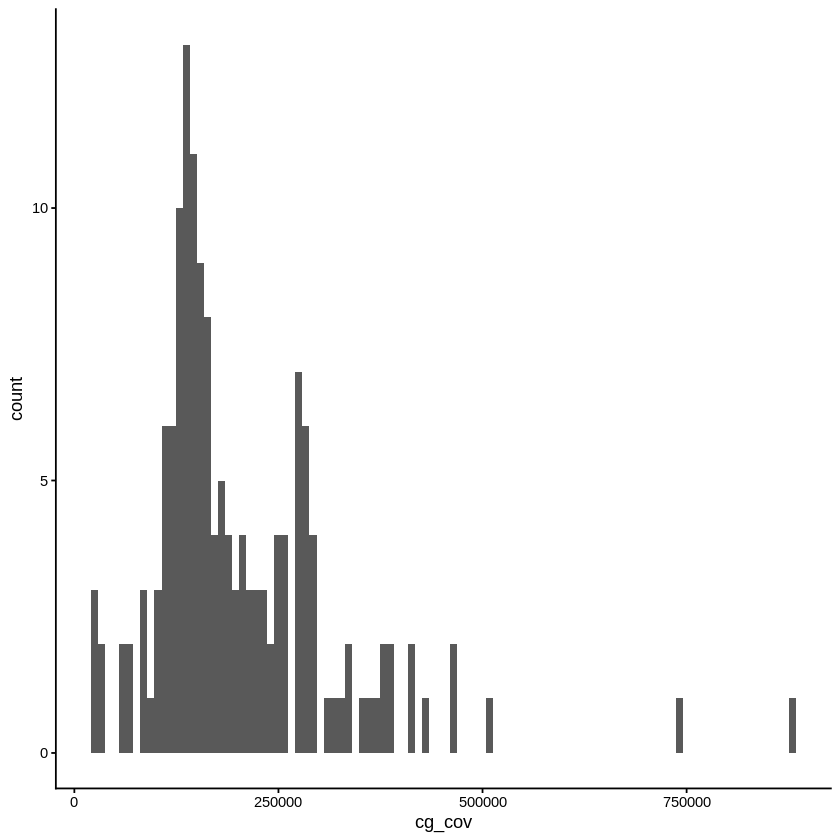

In [40]:
ggplot(obj@metadata, aes(x = cg_cov)) +
  geom_histogram(bins = 100) +
  theme_classic()

### Filtering on CGs covered
Lets just filter out data a bit to remove those high and low coverage cells. This will help reduce technical bias in our analysis. Let's define a threshold and plot it over our histogram, just to visually check. And then lets apply these thresholds as a filter for our cells.

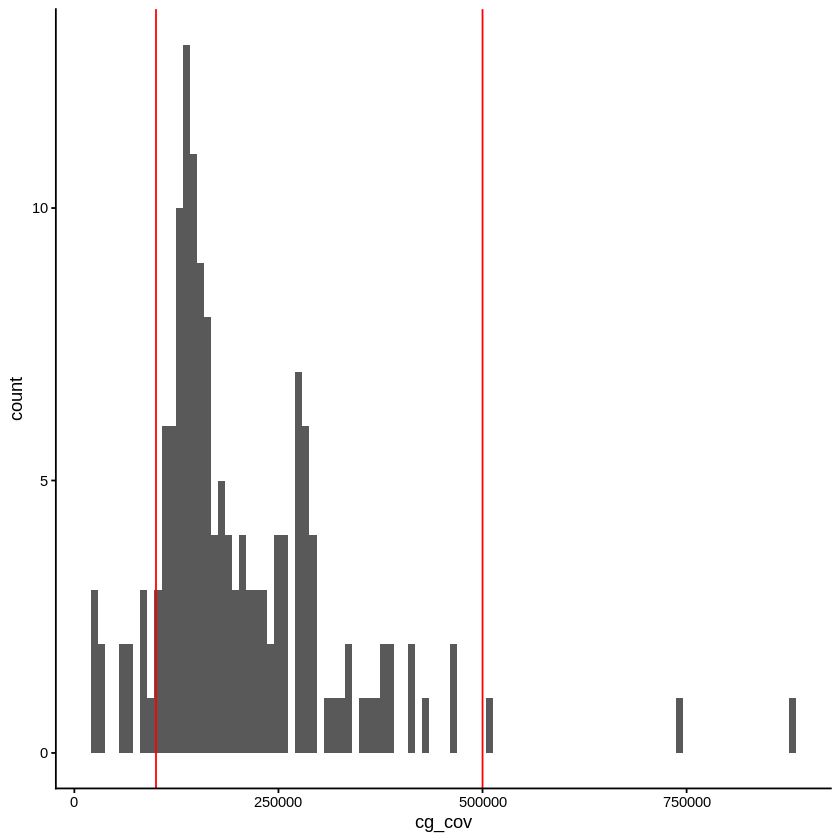

In [41]:
ggplot(obj@metadata, aes(x = cg_cov)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  geom_vline(xintercept=c(100000,500000),color="red")

Here we are combining a couple elements of R programming.

First we will use the data structure hierarchy to call the metadata column we want:


```
obj@metadata$cg_cov
```

Then we will check if that value, per cell is greater than 100,000:



```
obj@metadata$cg_cov>100000
```

This gives us a list, the same length as obj@metadata$cg_cov of just TRUE or FALSE. For if that cell does pass that filter. We can apply the second threshold to make two lists of TRUE or FALSE and add them together, so only cells that are TRUE in both lists are maintained as TRUE.



```
obj@metadata$cg_cov>100000 & obj@metadata$cg_cov<500000
```

Finally, we use the function


> *which()* This simply takes all the TRUE values in the list, and gives us their index, which is equivalent to their row number.

So from this, we can subset the obj@metadata data frame and get all the passing cell IDs in a single line of strung together code.

Finally, we will use a amethyst function:



> *subsetObject()* takes a list of cells and removes all others.

This is convenient for us, because it will look through all the slots in one call.










In [42]:
#first we make a list of cells that are within the thresholds
cells_pass_qc<-row.names(obj@metadata[which(obj@metadata$cg_cov>100000 & obj@metadata$cg_cov<500000),])

#then we use the subset Object function to keep only passing cells
obj<-subsetObject(obj,cells=cells_pass_qc)

#a final check of cell counts per sample
table(obj@metadata$sample)


    MCF10A       MCF7 MDA-MB-231 
        50         47         40 

### QC Plot: Percent mCG

And lets check the percent methylation. For most cells this ranging from about 60% to 80% depending on cell type. Cancer and cell lines tend to be on the lower end generally.

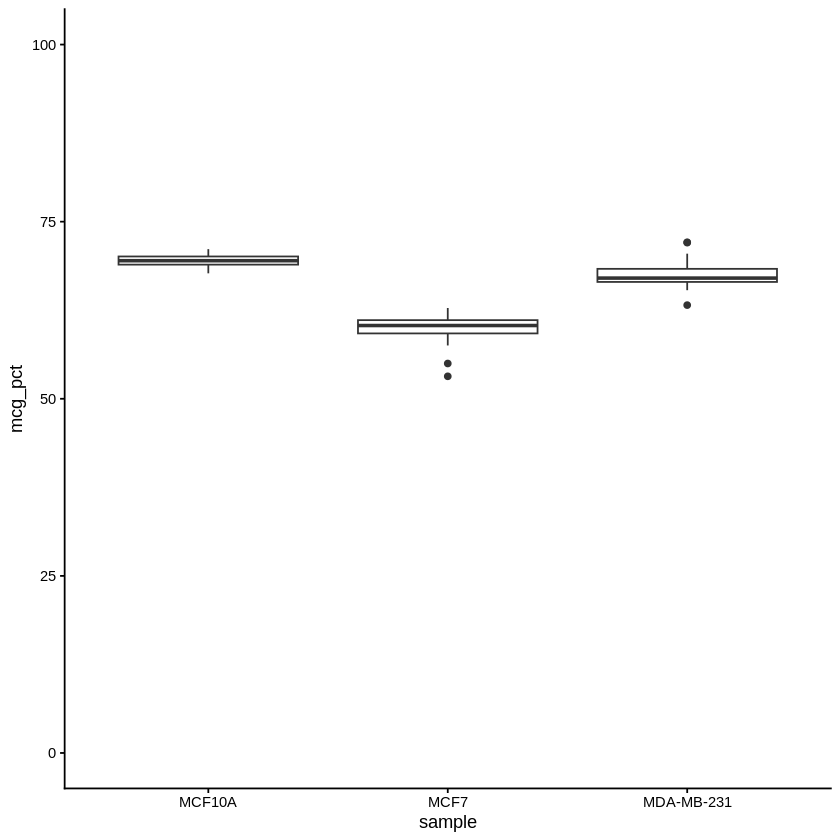

In [43]:
ggplot(obj@metadata, aes(x = sample,y=mcg_pct)) +
  geom_boxplot() +
  theme_classic() +
  ylim(c(0,100))

# Indexing and Methylation Windows

### Indexing H5

First we will index our CG sites in our h5 files. This will allow us to access them for summarizing over windows with much improved memory efficiency.



> *indexChr()* generates indexes for h5 files, so the whole file does not need to be stored in memory.

This takes a few min to run...


We can now take a peek at some chr1 data.

In [44]:
obj@index[["chr_cg"]] <- indexChr(obj, type = "CG", threads = 3)
head(obj@index[["chr_cg"]][["chr1"]])

cell_id,chr,start,count
<chr>,<chr>,<int>,<int>
CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,chr1,2244,47937
GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,chr1,1621,45457
GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,chr1,1782,36557
AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,chr1,1676,36758
TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,chr1,873,34662
CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,chr1,1574,29290


### Filtering out Scaffolds
Next let's filter down to just chromosomes. Reference genomes tend to have excess contigs/scaffolds that are gene-poor and lower quality mapping regions.

Similar to how we filtered cells passing a CG count threshold, we can filter chromosomes just based on name.

To generate our TRUE/FALSE list I am using the function:


> *startsWith()* This function takes a string (our contig) and checks if it starts with a given prefix, in this case ("chr")

We **negate** this result with a **!** meaning, contigs that **DON'T** start with "chr" are passed on to our if statement.

We then take those non-chromosome contigs and remove them by resetting them as "NULL" in our object.



In [46]:
#filter to just autosomes
chr_names<-names(obj@index[["chr_cg"]])
print("All contigs:")
print(chr_names)

for(contig in chr_names){
  if(!startsWith(x=contig,prefix="chr")){
    obj@index[["chr_cg"]][[contig]]<-NULL
  }
}

chr_names<-names(obj@index[["chr_cg"]])
print("Chromosomes passing filter:")
print(chr_names)

[1] "All contigs:"
  [1] "chr1"       "chr10"      "chr11"      "chr12"      "chr13"     
  [6] "chr14"      "chr15"      "chr16"      "chr17"      "chr18"     
 [11] "chr19"      "chr2"       "chr20"      "chr21"      "chr22"     
 [16] "chr3"       "chr4"       "chr5"       "chr6"       "chr7"      
 [21] "chr8"       "chr9"       "chrX"       "chrY"       "GL000008.2"
 [26] "GL000009.2" "GL000194.1" "GL000195.1" "GL000205.2" "GL000208.1"
 [31] "GL000213.1" "GL000214.1" "GL000216.2" "GL000218.1" "GL000219.1"
 [36] "GL000220.1" "GL000221.1" "GL000224.1" "GL000225.1" "GL000226.1"
 [41] "KI270302.1" "KI270303.1" "KI270304.1" "KI270305.1" "KI270310.1"
 [46] "KI270311.1" "KI270317.1" "KI270320.1" "KI270322.1" "KI270330.1"
 [51] "KI270333.1" "KI270336.1" "KI270337.1" "KI270362.1" "KI270363.1"
 [56] "KI270366.1" "KI270378.1" "KI270382.1" "KI270383.1" "KI270387.1"
 [61] "KI270390.1" "KI270393.1" "KI270394.1" "KI270395.1" "KI270414.1"
 [66] "KI270417.1" "KI270418.1" "KI270419.1" "KI270420.1" 

### Summarizing Methylation Signal over Genomic Windows

Single cell methylation data is **sparse**. Meaning the likelihood that we capture the same CG site across many cells is low. Our data has roughly 200k CGs covered per cell, but thats just a fraction of the 28M in the human genome. To get around this sparsity, we use larger windows that are biologically co-regulated, these are generally 500bp-5kbp in size.

For our workshop, we are going to use 5Mbp windows, which are huge! But these cell lines should be different enough to still cluster. For real analysis you will need a high powered computing cluster to calculate smaller windows for more cells.

Also note, we are using "**score**" as a metric rather than "**percent**".

This is because we are correcting for differences in coverage per cell across windows. Basically the more reads we have in a window, the more confident we are in the methylation signature there.

This takes about 5 to 6min...

In [47]:
obj@genomeMatrices[["cg_5mb_score"]] <- makeWindows(obj,
                                                    stepsize = 5000000,
                                                    type = "CG",
                                                    metric = "score",
                                                    threads = 4,
                                                    index = "chr_cg",
                                                    nmin = 2)


Completed  chr1 

Completed  chr10 

Completed  chr11 

Completed  chr12 

Completed  chr13 

Completed  chr14 

Completed  chr15 

Completed  chr16 

Completed  chr17 

Completed  chr18 

Completed  chr19 

Completed  chr2 

Completed  chr20 

Completed  chr21 

Completed  chr22 

Completed  chr3 

Completed  chr4 

Completed  chr5 

Completed  chr6 

Completed  chr7 

Completed  chr8 

Completed  chr9 

Completed  chrX 

Completed  chrY 


### Filtering Windows

We can also filter windows that don't have good coverage. Methylation profiling methods rely on inducing point mutations and creates sites that are difficult to map. We can filter those sites out.

In [48]:
#filter to windows with 90% of cells have data
obj@genomeMatrices[["cg_5mb_score"]] <- obj@genomeMatrices[["cg_5mb_score"]][rowSums(!is.na(obj@genomeMatrices[["cg_5mb_score"]])) >= nrow(obj@metadata)*.9, ]

win_count<-nrow(obj@genomeMatrices[["cg_5mb_score"]])
print(paste(win_count,"windows passed filter."))


[1] "598 windows passed filter."


# Clustering

Now that we have our summarized windows, we can perform clustering.

Methylation, like RNA or ATAC data is clustered by first using a dimensionality reduction (PCA, IRLBA, LSI) to reduce features while accounting for feature-feature correlations.

We will use two functions in this block:



> *dimEstimate()* takes in the matrix and estimates the top variable components to a certain threshold.

> *runIrlba()* runs the dimensionality reduction, using a PCA that can handle NA values.


In [49]:
#can run a dimensionality estimate to see how many principal components are informative
dimEstimate(obj, genomeMatrices = c("cg_5mb_score"), dims = c(10), threshold = 0.95)

set.seed(111)

# name the result whatever you want. I like descriptive names, at the cost of length.
# run a modified PCA (IRLBA) which accounts for NA values
obj@reductions[["irlba_cg_5mb_score"]] <- runIrlba(obj, genomeMatrices = c("cg_5mb_score"), dims = c(5), replaceNA = c(0))


cg_5mb_score 
           3

Because our methylation values per window is weighed by confidence, we have some principal components which may have a strong coverage bias. I.e. they are capturing technical artifacts rather than real biology. To fix this, we can regress out the coverage per each PC.

 We will use


> *regressCovBias()* to do this. It will look for our metadata column "*cov*" for regression.



In [50]:
#regress out coverage across the PCs to mitigate sequencing and QC effects on biology
obj@reductions[["irlba_cg_5mb_score_regressed"]] <- regressCovBias(obj, reduction = "irlba_cg_5mb_score")

With our regressed PCs we can now run our clustering to group cells in similar space together.



> *runCluster()* this will wrap Rphenograph, a function to group cells by louvain clustering.



In [57]:
#cluster cells in shared space
obj <- runCluster(obj, k=50, reduction = "irlba_cg_5mb_score_regressed")
table(obj@metadata$cluster_id) #get a count of cells per cluster

Run Rphenograph starts:
  -Input data of 137 rows and 5 columns
  -k is set to 50



  Finding nearest neighbors...DONE ~ 0.014 s
  Compute jaccard coefficient between nearest-neighbor sets...DONE ~ 0.683 s
  Build undirected graph from the weighted links...DONE ~ 0.035 s
  Run louvain clustering on the graph ...DONE ~ 0.01 s


Run Rphenograph DONE, totally takes 0.742000000001099s.



  Return a community class
  -Modularity value: 0.417977 
  -Number of clusters: 3


 1  2  3 
50 49 38 

Now that we have our clusters together, lets cram them into 2D space!



> *amethyst::runUmap()* UMAP wrapper for amethyst, given our coverage regressed PCs, using euclidean distance.

Notably, in this function call, we first define the package we want the function from "amethyst::" this is because copykit has a function called runUmap too! It is good form to identify the package for functions (but in most cases you don't have mutiple functions with the same name, so its okay).


In [52]:
#run umap to visualize in 2D
obj <- amethyst::runUmap(obj, method = "euclidean", reduction = "irlba_cg_5mb_score_regressed")

Now let's plot! We will use the amethyst function:

>*dimFeature()* to plot our umap reduction by various metadata columns.

We can then plot all our plots together (p1,p2,p3,p4) for ease of visualization using the library cow_plot's *plot_grid()* function.



[1] "Plotting..."


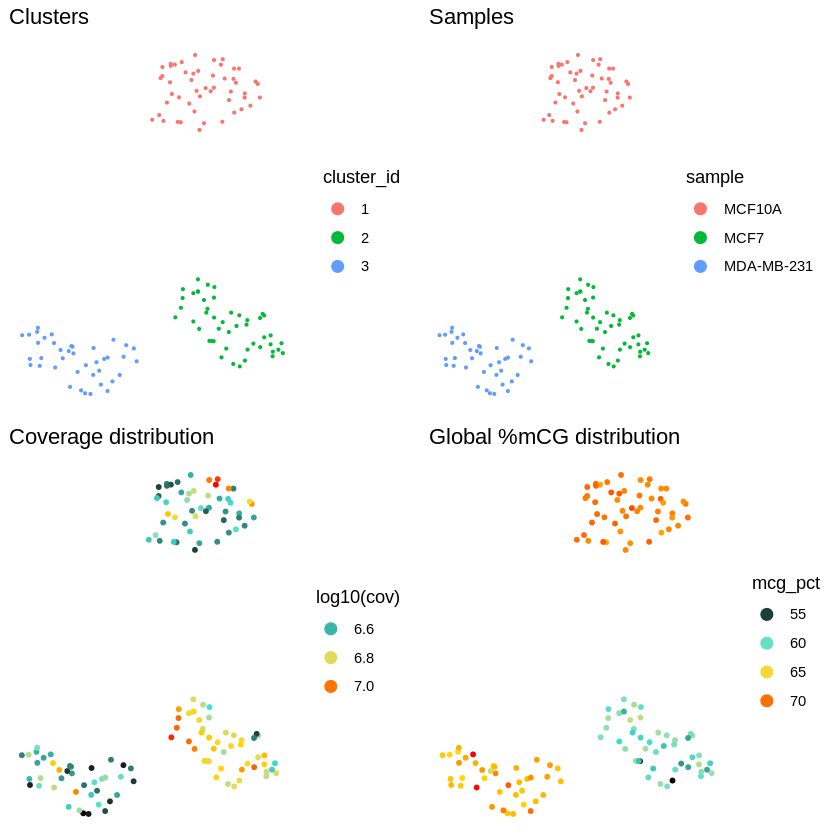

In [53]:
#plot by multiple metadata columns for visualization
print("Plotting...")
p1 <- dimFeature(obj, colorBy = cluster_id, reduction = "umap") + ggtitle("Clusters")
p2 <- dimFeature(obj, colorBy = sample, reduction = "umap") + ggtitle("Samples")
p3 <- dimFeature(obj, colorBy = log10(cov), pointSize = 1) + scale_color_gradientn(colors = c("black", "turquoise", "gold", "red"),guide="colourbar") + ggtitle("Coverage distribution")
p4 <- dimFeature(obj, colorBy = mcg_pct, pointSize = 1) + scale_color_gradientn(colors = c("black", "turquoise", "gold", "red")) + ggtitle("Global %mCG distribution")
plt<-plot_grid(p1, p2,p3, p4,ncol=2)
plt

Let's compare our cell line metadata in "sample" to our assigned "cluster_id" from the *runCluster* function above.

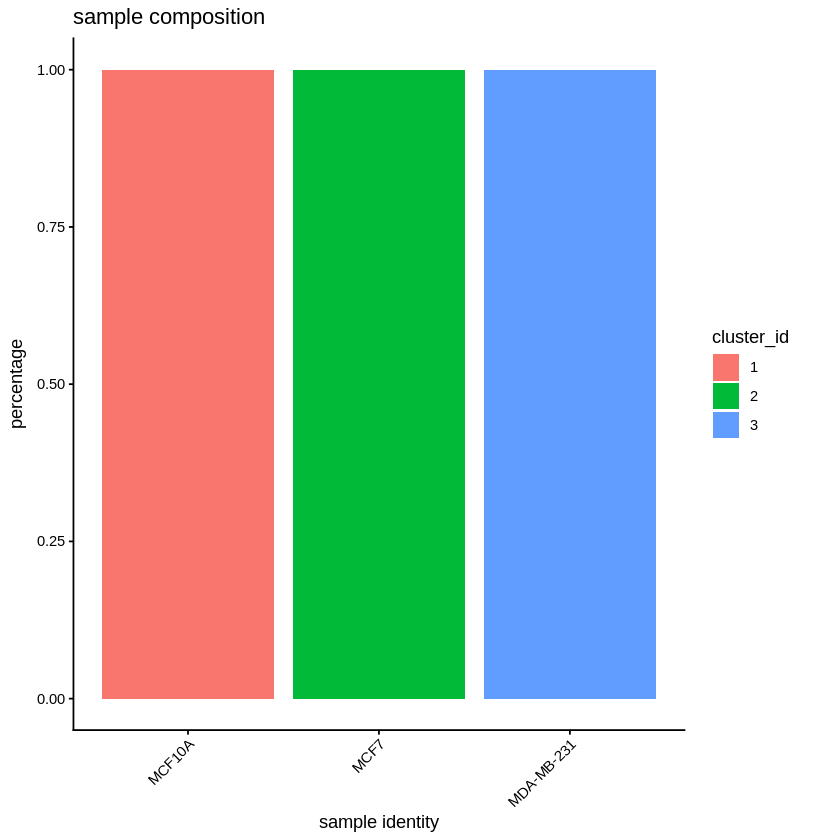

In [54]:
sampleComp(obj, groupBy = "sample", colorBy = "cluster_id")


Remember! This is all being done on 5mb windows, which are about 1000x larger than standard methylome processing!

I pre-baked the methylation summarized over much smaller windows, which we can use to visualize genomic regions in more detail. Let's download it and load it into our amethyst object.

In [55]:
system("gdown '1f6OdHmrR24K337_RX1x1eSgC_QrcLWWd'") #download it
tracks<-readRDS("celltype_500bpwindow_tracks.rds") #load it into R
obj@genomeMatrices[["cg_cluster_tracks"]] <- tracks[["pct_matrix"]] #load it into amethyst object
obj@ref <- makeRef("hg38")

Let's use two other amethyst plotting functions to look at methylation over some genes of interest!

Let's compare and contrast using *heatMap()* and *histograM()* for visualization. Which do you think is more clear?



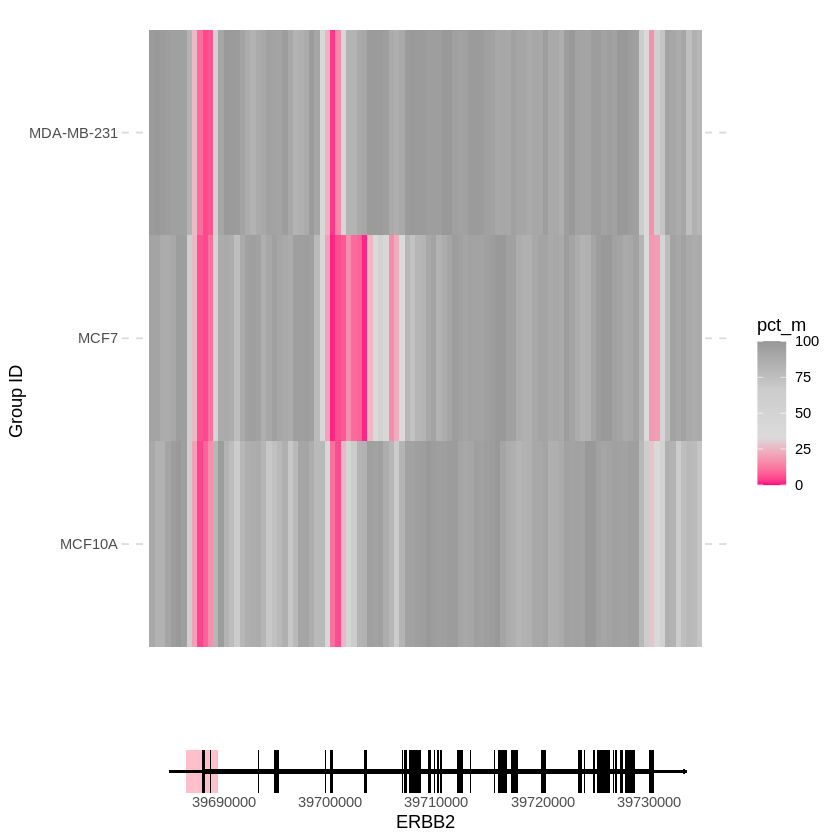

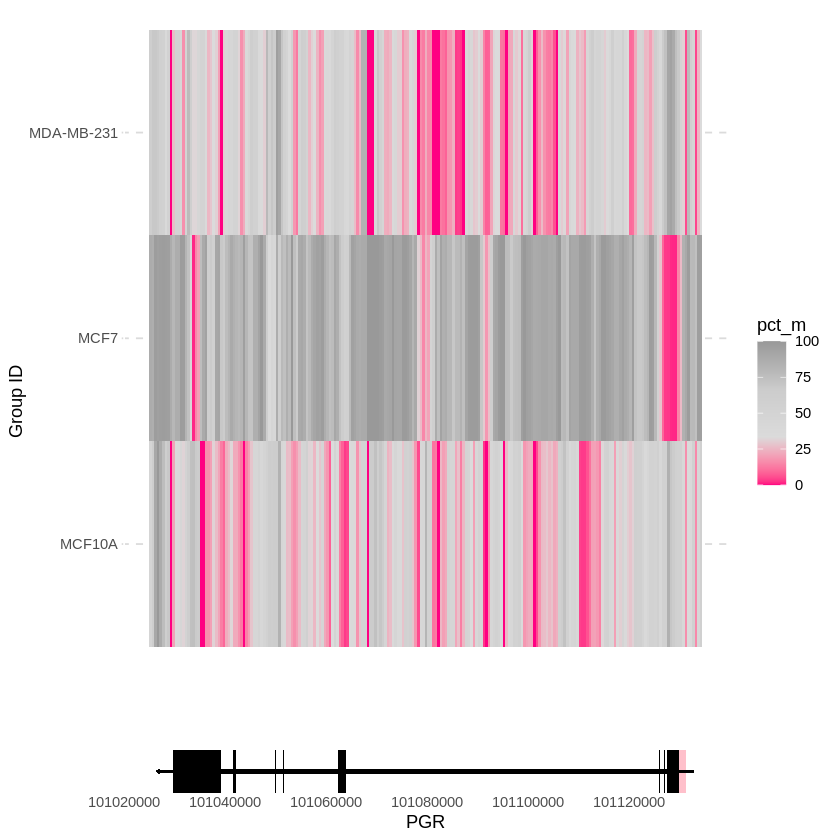

In [56]:
amethyst::heatMap(obj,
        genes = c("ERBB2"),
        matrix = "cg_cluster_tracks",
        legend = T)

amethyst::heatMap(obj,
        genes = c("PGR"),
        matrix = "cg_cluster_tracks",
        legend = T)

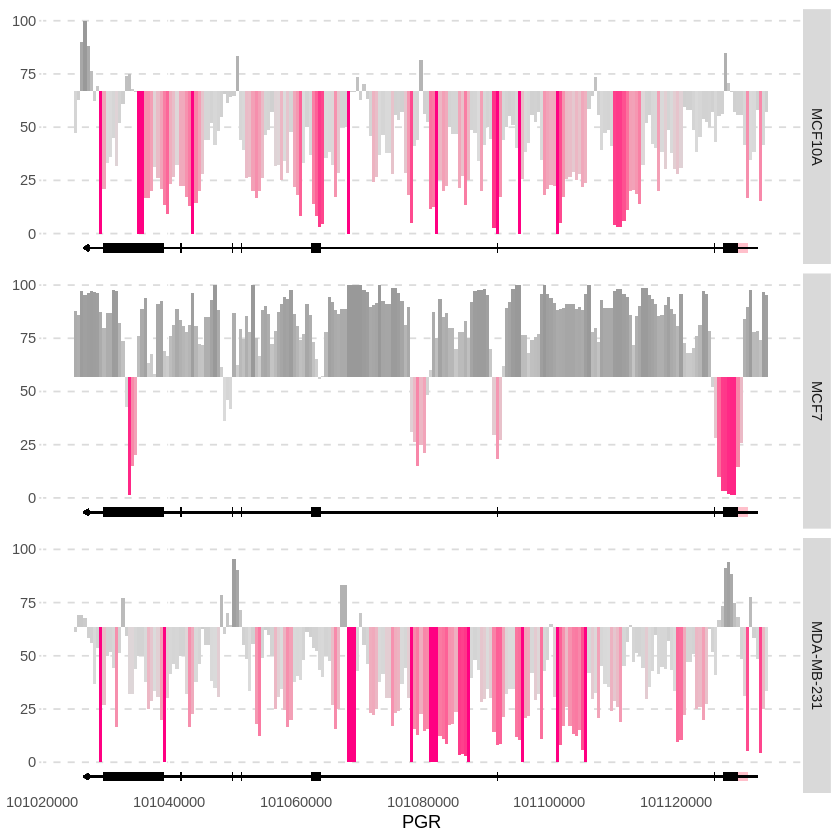

In [ ]:
histograM(obj,
          baseline = "mean",
          genes = "PGR",
          matrix = "cg_cluster_tracks",
          legend = F)

# Conclusion

So we went from compressed files of chromosome, location, methylation for about 150 cells all the way to UMAP clustering, and genomic window visualization! Not bad for an hour!

Of course this is plenty more you can do with methylation data, and this just serves as an intro!

Here's some other topics with existing packages to explore:


*   Identification of differentially methylated regions (DMRs)
*   Methylation based lineage analysis via [MethylTree](https://github.com/ShouWenWang-Lab/MethylTree/tree/master)
* Copy number calling by alignment rates across the genome via [copykit](https://github.com/navinlabcode/copykit)
* Methylation clock analysis for relative sample and cell type aging via [scAGE](https://github.com/alex-trapp/scAge)

Amethyst has plenty more resources and functions we didn't touch on! Please feel free to peruse their [vignettes](https://github.com/lrylaarsdam/amethyst) and example data for more!

# Bonus Sections

I included some bonus sections, time allowing, that we can delve into a bit deeper.

In [ ]:
#dmrs <- testDMR(tracks[["sum_matrix"]], # Sum of c and t observations in each genomic window per group
#                eachVsAll = TRUE, # If TRUE, each group found in the sumMatrix will be tested against all others
#                nminTotal = 5, # Min number observations across all groups to include the region in calculations
#                nminGroup = 5) # Min number observations across either members or nonmembers to include the region in calculations
#dmrs <- filterDMR(dmrs,
#                method = "bonferroni", # c("holm", "hochberg", "hommel", "bonferroni", "BH", "BY", "fdr")
#                filter = TRUE, # If TRUE, removes insignificant results
#                pThreshold = 0.01, # Maxmimum adjusted p value to allow if filter = TRUE
#                logThreshold = 1.5) # Minimum absolute value of the log2FC to allow if filter = TRUE
#                head(dmrs)


#collapsed_dmrs <- collapseDMR(obj,
#                dmrs,
#                maxDist = 2000, # Max allowable overlap between DMRs to be considered adjacent
#                minLength = 2000, # Min length of collapsed DMR window to include in the output
#                reduce = T, # Reduce results to unique observations (recommended)
#                annotate = T) # Add column with overlapping gene names



#collapsed_dmrs$type <- dplyr::recode(collapsed_dmrs$test,
#                "1_all" = "T",
#               "2_all" = "NK",
#                "3_all" = "B",
#                "4_all" = "Mono")

#ggplot(collapsed_dmrs |> dplyr::group_by(type, direction) |> dplyr::summarise(n = n()),
#       aes(y = type, x = n, fill = type)) + geom_col() +
#       facet_grid(vars(direction), scales = "free_y") + scale_fill_manual(values = pal) + theme_classic()

# Copy number calling

In [ ]:
#install one more package I forgot
#BiocManager::install("GenomeInfoDb")

In [ ]:
#cnv<-readRDS("workshop.copykit.obj.rds")
#cnv

Let's remove the cells that didn't pass the methylation QC. For copykit, metadata is stored in a different place. If we call the structure, you can see the hierarchical layout.

In [ ]:
#str(cnv)

In [ ]:
#cnv<-runVst(cnv)
#cnv<-suppressWarnings(runSegmentation(cnv))
#cnv<-logNorm(cnv)
#cnv <- suppressWarnings(knnSmooth(cnv))
#cnv <- copykit::runUmap(cnv)
#cnv <- findClusters(cnv)

#plotUmap(cnv, label = 'sample')

#plotHeatmap(
#  cnv,
#  label = 'sample',
#  genes = c("TP53", "BRAF", "MYC"))